### ASTR 3300/ PHYS 5300-003: Astrostatistics
***N. Pol***
___

# Homework 7
### Due: Friday, Apr. 4, at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

In [1]:
# install the relevant interactive plot packages
# only do this once
!pip install ipywidgets ipympl

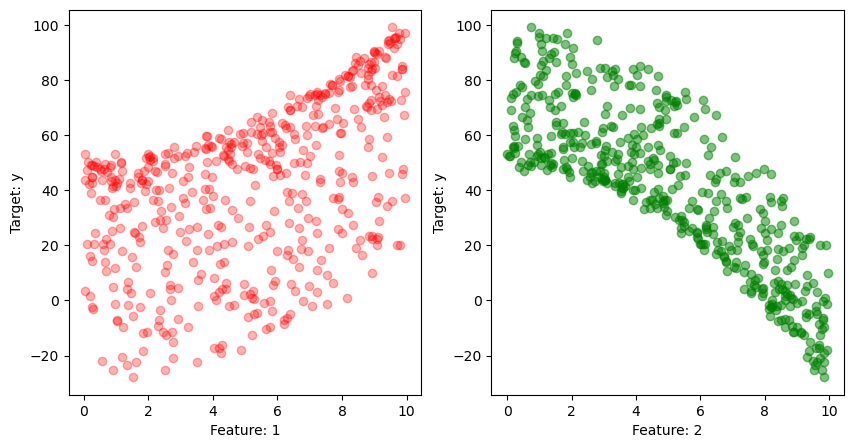

In [13]:
#SOLUTION 1

import numpy as np
import matplotlib.pyplot as plt
from astroML.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

data = np.load('/home/shwetha/ASTR_3300_S2025/coursework/homeworks/hw_data/hw7_data_1.npy')
X = data[:,:2]  
y = data[:,2]  
yerr = data[:,3] 


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(X[:,0], y, c='red', alpha=0.3)
axes[0].set_xlabel('Feature: 1')
axes[0].set_ylabel('Target: y')

axes[1].scatter(X[:, 1], y, c='green', alpha=0.5)
axes[1].set_xlabel('Feature: 2')
axes[1].set_ylabel('Target: y')

plt.show()

Best-fit Intercept: 4.948730161178383
Best-fit Slope: 57.101023232995466


I think it's a decent prediction


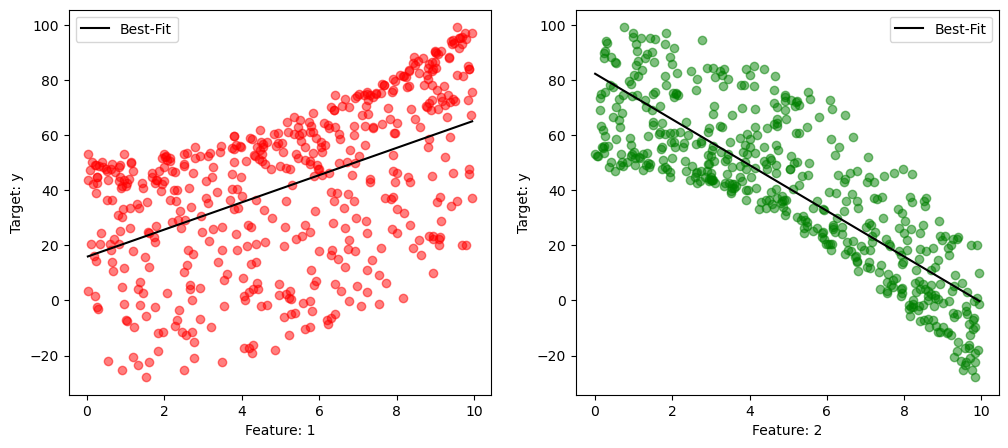

In [3]:
#SOLUTION 2

model = LinearRegression()
model.fit(X,y,yerr)

print("Best-fit Intercept:", model.coef_[1])
print("Best-fit Slope:", model.coef_[0])

Xgrid_1 = np.linspace(X[:,0].min(), X[:,0].max(), 50)
Xgrid_2 = np.linspace(X[:,1].min(), X[:,1].max(), 50)
Xgrid = np.column_stack([Xgrid_1, Xgrid_2])
y_pred = model.predict(Xgrid)

X1_pred = model.predict(np.column_stack([Xgrid_1, np.full_like(Xgrid_1, np.mean(X[:,1]))]))
X2_pred = model.predict(np.column_stack([np.full_like(Xgrid_2, np.mean(X[:,0])), Xgrid_2]))

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(X[:,0], y, c='red', alpha=0.5)
axes[0].plot(Xgrid_1, X1_pred, 'k-', label='Best-Fit')
axes[0].set_xlabel('Feature: 1')
axes[0].set_ylabel('Target: y')
axes[0].legend()

axes[1].scatter(X[:,1], y, c='green', alpha=0.5)
axes[1].plot(Xgrid_2, X2_pred, 'k-', label='Best-Fit')
axes[1].set_xlabel('Feature: 2')
axes[1].set_ylabel('Target: y')
axes[1].legend()
print("\n")
print("I think it's a decent prediction")

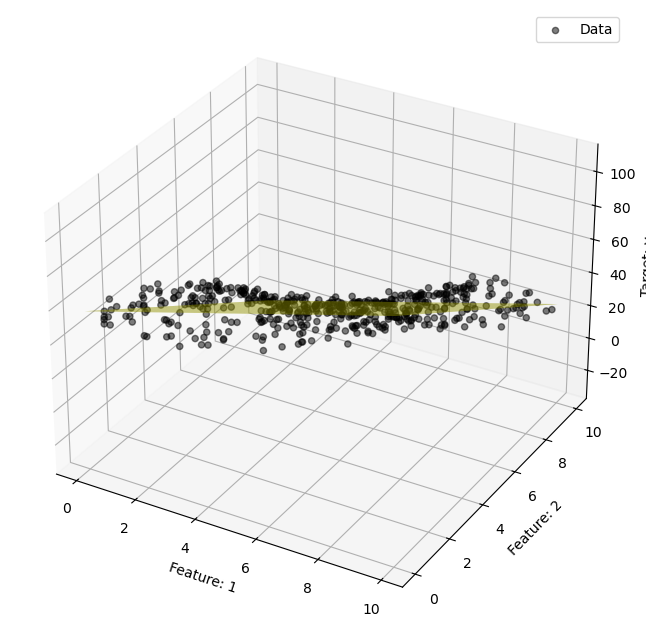

In [4]:
Xgrid_1, Xgrid_2 = np.meshgrid(Xgrid_1, Xgrid_2)
Xgrid_mesh = np.column_stack([Xgrid_1.ravel(), Xgrid_2.ravel()])
y_pred_mesh = model.predict(Xgrid_mesh).reshape(Xgrid_1.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c='black', alpha=0.5, label='Data')
ax.plot_surface(Xgrid_1, Xgrid_2, y_pred_mesh, color='yellow', alpha=0.6)
ax.set_xlabel('Feature: 1')
ax.set_ylabel('Feature: 2')
ax.set_zlabel('Target: y')
plt.legend()
plt.show()


In [5]:
### Always do this line at the start
### of a static plotting cell
%matplotlib inline

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

In [6]:
#Solution 4

ridge_params = {'alpha': [0.05, 0.1, 0.2, 0.5, 1.0], 'solver': ['svd', 'lsqr']}
grid_search = GridSearchCV(Ridge(), ridge_params, cv=5)
grid_search.fit(X, y)

print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best score from GridSearchCV:", grid_search.best_score_)

ridge_best = grid_search.best_estimator_

ridge_cv = RidgeCV(alphas=[0.05, 0.1, 0.2, 0.5, 1.0], store_cv_results=True)
ridge_cv.fit(X, y)

print("RidgeCV α):", ridge_cv.alpha_)

Best parameters from GridSearchCV: {'alpha': 1.0, 'solver': 'svd'}
Best score from GridSearchCV: 0.9290800590702192
RidgeCV α): 1.0


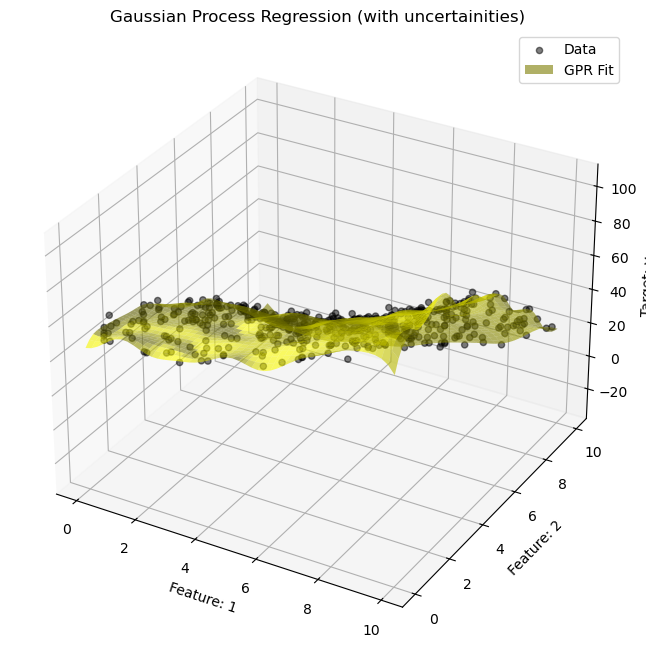

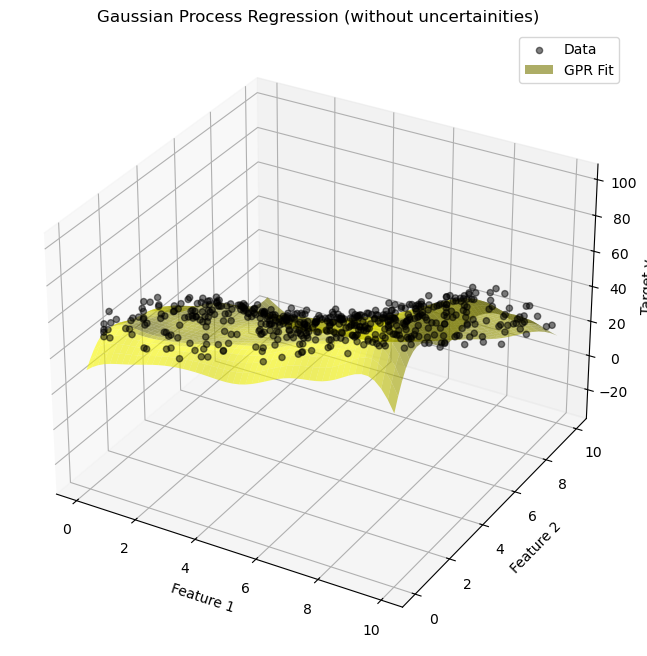

In [7]:
#Solution 5

alpha = (yerr/y)**2  
gpr = GaussianProcessRegressor(alpha=alpha)
gpr.fit(X, y)

Xgrid_1 = np.linspace(X[:,0].min(), X[:,0].max(), 50)
Xgrid_2 = np.linspace(X[:,1].min(), X[:,1].max(), 50)
Xgrid_1, Xgrid_2 = np.meshgrid(Xgrid_1, Xgrid_2)
Xgrid = np.column_stack([Xgrid_1.ravel(), Xgrid_2.ravel()])
y_pred_gpr = gpr.predict(Xgrid).reshape(Xgrid_1.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c='black', alpha=0.5, label='Data')
ax.plot_surface(Xgrid_1, Xgrid_2, y_pred_gpr, color='yellow', alpha=0.6, label='GPR Fit')
ax.set_xlabel('Feature: 1')
ax.set_ylabel('Feature: 2')
ax.set_zlabel('Target: y')
ax.set_title('Gaussian Process Regression (with uncertainities)')
plt.legend()
plt.show()


#--------------------------------------------------------------------------------------------


alpha = 1.0
gpr = GaussianProcessRegressor(alpha=alpha)
gpr.fit(X, y)


Xgrid_1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
Xgrid_2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)
Xgrid_1, Xgrid_2 = np.meshgrid(Xgrid_1, Xgrid_2)
Xgrid_ = np.column_stack([Xgrid_1.ravel(), Xgrid_2.ravel()])
y_pred_gpr = gpr.predict(Xgrid).reshape(Xgrid_1.shape)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c='black', alpha=0.5, label='Data')
ax.plot_surface(Xgrid_1, Xgrid_2, y_pred_gpr, color='yellow', alpha=0.6, label='GPR Fit')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target y')
ax.set_title('Gaussian Process Regression (without uncertainities)')
plt.legend()
plt.show()

Best-fit Polynomial regression coefficients: [ 2.50181833e+01  2.50181833e+01  3.26437755e-01  7.04566290e-02
  3.76478281e-01 -2.37398556e-02 -8.70986046e-01  1.19122182e-02
  2.54637597e-02 -1.32002013e-02  2.02705370e-02 -4.53796076e-04
 -5.21142180e-04 -2.06194460e-03  1.68744189e-03 -1.52054198e-03]


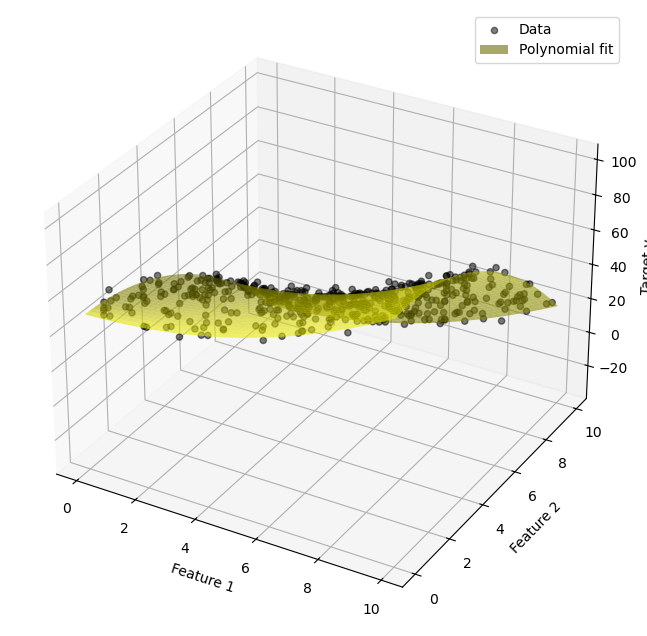

In [8]:
# Solution 6

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

print("Best-fit Polynomial regression coefficients:", poly_model.coef_)

Xgrid_poly = poly.transform(Xgrid)
y_pred_poly = poly_model.predict(Xgrid_poly)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, c='black', alpha=0.5, label='Data')
ax.plot_surface(Xgrid_1, Xgrid_2, y_pred_poly.reshape(Xgrid_1.shape), color='yellow', alpha=0.6, label='Polynomial fit')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target y')
plt.legend()
plt.show()

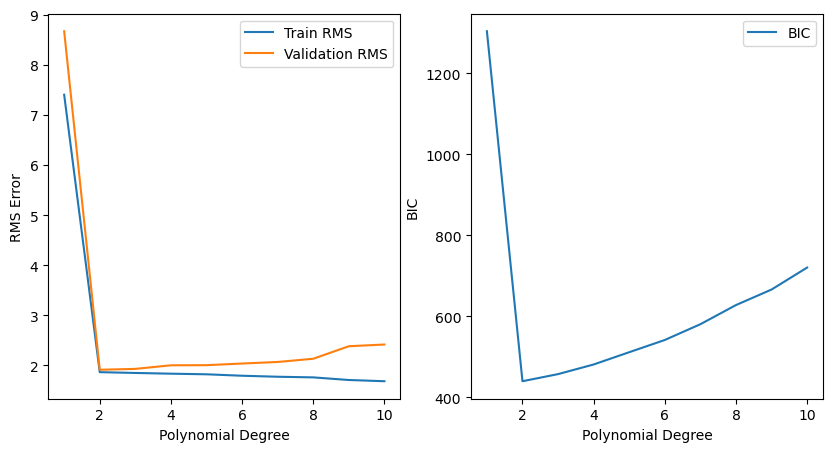

Testing RMS error for optimal polynomial degree: 2.047861597385806


In [20]:
#Solution 7

X_train, X_test, y_train, y_test, yerr_train, yerr_test = train_test_split(X, y, yerr, test_size=0.2)
X_train, X_val, y_train, y_val, yerr_train, yerr_val = train_test_split(X_train, y_train, yerr_train, test_size=0.2)

def calculate_bic(model, X, y, yerr):
    n = len(y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    bic = n * np.log(mse) + len(model.coef_) * np.log(n)
    return bic

rms_errors = []
bic_values = []

for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y_train)
    rms_train = np.sqrt(mean_squared_error(y_train, poly_model.predict(X_poly_train)))
    rms_val = np.sqrt(mean_squared_error(y_val, poly_model.predict(poly.transform(X_val))))
    rms_errors.append((rms_train, rms_val))
    bic_train = calculate_bic(poly_model, X_poly_train, y_train, yerr_train)
    bic_values.append(bic_train)


degrees = np.arange(1, 11)
train_errors, val_errors = zip(*rms_errors)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(degrees, train_errors, label="Train RMS")
plt.plot(degrees, val_errors, label="Validation RMS")
plt.xlabel('Polynomial Degree')
plt.ylabel('RMS Error')

plt.legend()
plt.subplot(1, 2, 2)
plt.plot(degrees, bic_values, label="BIC")
plt.xlabel('Polynomial Degree')
plt.ylabel('BIC')
plt.legend()
plt.show()

optimal_degree = np.argmin(val_errors) + 1
poly = PolynomialFeatures(degree=optimal_degree)
X_poly_full = poly.fit_transform(X_train)
poly_model.fit(X_poly_full, y_train)
y_pred_test = poly_model.predict(poly.transform(X_test))
rms_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Testing RMS error for optimal polynomial degree:", rms_test)


<span style="color:green">NP: correct! good job!</span>